<a href="https://colab.research.google.com/github/nMaax/danteGPT/blob/main/dante_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data loading and tokenization

In [1]:
!wget https://raw.githubusercontent.com/nMaax/danteGPT/main/divina_commedia.txt

--2025-03-19 22:10:34--  https://raw.githubusercontent.com/nMaax/danteGPT/main/divina_commedia.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 535249 (523K) [text/plain]
Saving to: ‘divina_commedia.txt’

divina_commedia.txt 100%[===================>] 522.70K  --.-KB/s    in 0.02s   

2025-03-19 22:10:34 (32.8 MB/s) - ‘divina_commedia.txt’ saved [535249/535249]



In [2]:
# Read the file
with open('divina_commedia.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [3]:
print(text[:10000])

INFERNO CANTO 1
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura
ché la diritta via era smarrita.
Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!
Tant' è amara che poco è più morte;
ma per trattar del ben ch'i' vi trovai,
dirò de l'altre cose ch'i' v'ho scorte.
Io non so ben ridir com' i' v'intrai,
tant' era pien di sonno a quel punto
che la verace via abbandonai.
Ma poi ch'i' fui al piè d'un colle giunto,
là dove terminava quella valle
che m'avea di paura il cor compunto,
guardai in alto, e vidi le sue spalle
vestite già de' raggi del pianeta
che mena dritto altrui per ogne calle.
Allor fu la paura un poco queta
che nel lago del cor m'era durata
la notte ch'i' passai con tanta pieta.
E come quei che con lena affannata
uscito fuor del pelago a la riva
si volge a l'acqua perigliosa e guata,
così l'animo mio, ch'ancor fuggiva,
si volse a retro a rimirar lo passo
che non lasciò già mai persona viva.
Poi ch'èi 

In [4]:
from collections import Counter
import regex as re

class BasicTokenizer():
  def __init__(self,):
    self.merges = None
    self.rev_merges = None
    self.vocab = None

  def train(self, text, vocab_size, verbose=False):

    num_to_merge = vocab_size - 256
    tokens = list(map(int, text.encode('utf-8')))
    _, self.merges, self.rev_merges = self.continuous_merge(tokens, num_to_merge)

  def encode(self, text):
    """
    Encodes text into merged tokens using a given merge map.

    - Converts text to UTF-8 byte tokens.
    - Iteratively applies merges, replacing bigrams with new indices.
    """
    merges=self.merges
    tokens = list(text.encode('utf-8'))  # Get byte representation
    for bigram, new_idx in merges.items():
        new_tokens = []
        i = 0
        while i < len(tokens):
            if i < len(tokens) - 1 and (tokens[i], tokens[i+1]) == bigram:
                new_tokens.append(new_idx)  # Merge the bigram
                i += 2  # Skip next token (merged)
            else:
                new_tokens.append(tokens[i])
                i += 1
        tokens = new_tokens  # Update tokens after each merge pass
    return tokens

  def decode(self, tokens):
    """Decodes merged tokens back into a UTF-8 string."""

    vocab = {token: bytes([token]) for token in range(256)}
    for (original_token_1, original_token_2), merged_token in self.merges.items():
        vocab[merged_token] = vocab[original_token_1] + vocab[original_token_2]
    self.vocab = vocab

    tokens = b"".join(vocab[token] for token in tokens)
    text = tokens.decode("utf-8", errors="replace")
    return text

  def count_bigrams(self, tokens):
    """Count bigrams using collections.Counter for efficiency."""
    return Counter(zip(tokens[:-1], tokens[1:]))

  def sort_counter(self, counter, reverse=True):
      """Sort bigrams by frequency.

      Returns a list of (count, bigram) tuples.
      """
      return sorted(((count, bigram) for bigram, count in counter.items()), reverse=reverse)

  def merge(self, tokens, bigram, new_idx):
      """
      Merge occurrences of `bigram` in the token list.

      Instead of modifying the list in place, build a new list.
      When a bigram is found, it is replaced by new_idx, and the second token is skipped.
      """
      new_tokens = []
      i = 0
      while i < len(tokens):
          if i < len(tokens) - 1 and (tokens[i], tokens[i+1]) == bigram:
              new_tokens.append(new_idx)
              i += 2  # Skip the next token as it's merged
          else:
              new_tokens.append(tokens[i])
              i += 1
      return new_tokens

  def continuous_merge(self, tokens, n_to_merge):
      """
      Merge tokens continuously for n_to_merge iterations.

      Operates on a copy of the tokens so that the original list is not modified.
      Returns the merged tokens and a mapping of the merged bigrams to new indices.
      """
      tokens = tokens.copy()  # Work on a copy to leave the original unchanged.
      # Compute a base index that is outside the valid UTF-8 range.
      base = 256
      merges = {}
      rev_merges = {}

      for merge_iteration in range(n_to_merge):
          counter = self.count_bigrams(tokens)
          if not counter:
              break
          sorted_counter = self.sort_counter(counter, reverse=True)
          # Get the most frequent bigram
          bigram_to_merge = sorted_counter[0][1]
          new_idx = base + merge_iteration
          tokens = self.merge(tokens, bigram_to_merge, new_idx)
          merges[bigram_to_merge] = new_idx
          rev_merges[new_idx] = bigram_to_merge
      return tokens, merges, rev_merges

class RegexTokenizer(BasicTokenizer):
  def __init__(self, pattern=None):
    super().__init__()
    # TODO: Improve specifically for Dante
    self.pattern = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+""" if not pattern else pattern

  def train(self, text, vocab_size, verbose=False):
    """
    Trains the tokenizer by performing byte-pair encoding on the tokenized text.
    - Uses regex-based initial tokenization.
    - Learns merges similar to BasicTokenizer.
    """
    num_to_merge = vocab_size - 256

    # split the text up into text chunks
    text_chunks = re.findall(self.pattern, text)

    # input text preprocessing
    tokenized_text = [list(chunk.encode("utf-8")) for chunk in text_chunks]
    _, self.merges, self.rev_merges = self.continuous_merge(tokenized_text, num_to_merge)

  def count_bigrams(self, tokenized_text):
    return Counter(bigram for word in tokenized_text for bigram in zip(word[:-1], word[1:]))

  def continuous_merge(self, tokenized_text, n_to_merge):
      """
      Merge tokens continuously for n_to_merge iterations.

      Operates on a copy of the tokens so that the original list is not modified.
      Returns the merged tokens and a mapping of the merged bigrams to new indices.
      """
      tokenized_text = tokenized_text.copy()  # Work on a copy to leave the original unchanged.

      # Compute a base index that is outside the valid UTF-8 range.
      base = 256
      merges = {}
      rev_merges = {}

      for merge_iteration in range(n_to_merge):
          counter = self.count_bigrams(tokenized_text=tokenized_text)
          if not counter:
              break
          sorted_counter = self.sort_counter(counter, reverse=True)
          # Get the most frequent bigram
          bigram_to_merge, count = max(counter.items(), key=lambda item: item[1])
          new_idx = base + merge_iteration
          tokenized_text = [self.merge(tokenized_word, bigram_to_merge, new_idx) for tokenized_word in tokenized_text]
          merges[bigram_to_merge] = new_idx
          rev_merges[new_idx] = bigram_to_merge
      return tokenized_text, merges, rev_merges

In [5]:
tokenizer_training_size = len(text) // 4
vocab_size = 500

Dantokenizer = RegexTokenizer()
Dantokenizer.train(text[:tokenizer_training_size], vocab_size=vocab_size)

In [6]:
encode = Dantokenizer.encode
decode = Dantokenizer.decode

In [7]:
print(decode(encode('Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura.')))

Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura.


## Baseline, Transformer-free model

In [8]:
import torch

In [9]:
data = torch.tensor(encode(text), dtype=torch.long)

In [10]:
print(data.shape, data.dtype)

torch.Size([259412]) torch.int64


In [11]:
n = int(0.9*len(data))
train_data = data[:n]
test_data = data[n:]

In [12]:
block_size = 8
x = train_data[:block_size]
y = train_data[1:block_size+1]

print("full tokenized sentence: ", data[:block_size+1])
print()
for t in range(block_size):
  print("context:", x[:t+1])
  print("target: ", y[t].item())

full tokenized sentence:  tensor([ 73,  78,  70,  69,  82,  78,  79, 445,  65])

context: tensor([73])
target:  78
context: tensor([73, 78])
target:  70
context: tensor([73, 78, 70])
target:  69
context: tensor([73, 78, 70, 69])
target:  82
context: tensor([73, 78, 70, 69, 82])
target:  78
context: tensor([73, 78, 70, 69, 82, 78])
target:  79
context: tensor([73, 78, 70, 69, 82, 78, 79])
target:  445
context: tensor([ 73,  78,  70,  69,  82,  78,  79, 445])
target:  65


In [13]:
torch.manual_seed(42)

def get_batch(split='train', batch_size=32, block_size=8):
  data = train_data if split=='train' else test_data
  ix = torch.randint(low=0, high=(len(data) - block_size), size=(batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  y = torch.clamp(y, 0, vocab_size - 1)
  return x, y

In [14]:
xb, yb = get_batch('train', batch_size=4, block_size=8)

In [15]:
print(xb.shape, xb, sep='\n')
print(yb.shape, yb, sep='\n')

torch.Size([4, 8])
tensor([[363, 328, 317, 348, 475, 266, 318, 321],
        [266,  97, 256, 330, 384, 362, 276, 388],
        [264, 293, 260, 297, 281, 353, 279, 261],
        [266, 438, 392,  97, 273, 111, 418, 280]])
torch.Size([4, 8])
tensor([[328, 317, 348, 475, 266, 318, 321, 441],
        [ 97, 256, 330, 384, 362, 276, 388, 277],
        [293, 260, 297, 281, 353, 279, 261, 361],
        [438, 392,  97, 273, 111, 418, 280, 265]])


In [16]:
xb, yb = get_batch('train')
for b in range(8):
  for t in range(block_size):
    context = xb[b, :t+1]
    target = yb[b, t]
    print(f"when the context is {context} then the target is {target}")

when the context is tensor([268]) then the target is 271
when the context is tensor([268, 271]) then the target is 65
when the context is tensor([268, 271,  65]) then the target is 392
when the context is tensor([268, 271,  65, 392]) then the target is 97
when the context is tensor([268, 271,  65, 392,  97]) then the target is 455
when the context is tensor([268, 271,  65, 392,  97, 455]) then the target is 339
when the context is tensor([268, 271,  65, 392,  97, 455, 339]) then the target is 32
when the context is tensor([268, 271,  65, 392,  97, 455, 339,  32]) then the target is 104
when the context is tensor([333]) then the target is 101
when the context is tensor([333, 101]) then the target is 260
when the context is tensor([333, 101, 260]) then the target is 101
when the context is tensor([333, 101, 260, 101]) then the target is 425
when the context is tensor([333, 101, 260, 101, 425]) then the target is 101
when the context is tensor([333, 101, 260, 101, 425, 101]) then the targ

In [17]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(42)

class naiveLM(nn.Module):
  def __init__(self, vocab_size, latent_space_dim):
    super().__init__()
    self.embedding_table = nn.Embedding(vocab_size, latent_space_dim)
    self.net = nn.Sequential(
        nn.Linear(in_features=latent_space_dim, out_features=latent_space_dim, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=latent_space_dim, out_features=latent_space_dim, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=latent_space_dim, out_features=latent_space_dim, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=latent_space_dim, out_features=vocab_size, bias=True)
    )

  def forward(self, idx):
    emb = self.embedding_table(idx)
    logits = self.net(emb)
    return logits

  def compute_loss(self, idx, targets):
    logits = self.forward(idx)
    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits, targets)
    return loss

  def generate(self, idx, max_new_tokens=32):
    for _ in range(max_new_tokens):
      logits = self.forward(idx) # B, T, C
      logits = logits[:, -1, :] # B, C
      probs = F.softmax(logits, dim=-1) # B, C
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1) # idx: (B, T) --> (B, T+1)
    return idx

In [18]:
model = naiveLM(vocab_size=vocab_size, latent_space_dim=32)

In [19]:
print(xb.shape, xb, sep='\n')

torch.Size([32, 8])
tensor([[268, 271,  65, 392,  97, 455, 339,  32],
        [333, 101, 260, 101, 425, 101,  32, 304],
        [354,  33,  10,  83,  39, 287, 278, 320],
        [266, 318, 301, 110, 257, 195, 185, 332],
        [267, 378, 291, 103, 292, 400, 275, 259],
        [ 97, 314, 424, 324, 265, 257, 346, 487],
        [116, 402, 115, 256, 108, 277, 105, 283],
        [118, 277, 282, 279,  97, 268, 271,  77],
        [ 32, 304, 349, 271, 488, 310, 438, 395],
        [260, 101, 425, 101, 375, 278, 315, 280],
        [315, 335,  97, 314, 347, 490, 260, 274],
        [302, 310, 319, 403, 281, 275, 310, 367],
        [297, 102, 262, 345,  10, 354, 434, 264],
        [342, 468, 260, 299, 122, 335, 105, 271],
        [ 32,  83, 448, 327,  97,  10, 318, 338],
        [ 99, 335, 111,  10, 109, 298, 479, 277],
        [315, 117, 262,  32,  86, 105, 114, 468],
        [105,  10, 100, 288, 272, 292, 299, 102],
        [300, 116, 277, 262, 493, 455, 391, 265],
        [325,  79, 296, 383, 3

In [20]:
logits = model.forward(xb)

In [21]:
print(logits.shape, logits, sep='\n')

torch.Size([32, 8, 500])
tensor([[[-0.0973,  0.0823,  0.1829,  ..., -0.0455,  0.0730, -0.0730],
         [-0.1163,  0.0633,  0.1870,  ..., -0.0152,  0.0755, -0.0414],
         [-0.1158,  0.0478,  0.1551,  ..., -0.0521,  0.0852, -0.0418],
         ...,
         [-0.1725,  0.0467,  0.1694,  ...,  0.0134,  0.1059, -0.0204],
         [-0.1276,  0.0478,  0.1942,  ...,  0.0238,  0.1155, -0.0239],
         [-0.1275,  0.0693,  0.1902,  ..., -0.0157,  0.0786, -0.0361]],

        [[-0.1081,  0.0403,  0.1779,  ..., -0.0557,  0.0740, -0.0516],
         [-0.1439,  0.0547,  0.1704,  ..., -0.0262,  0.0872, -0.0306],
         [-0.0964,  0.0279,  0.1664,  ..., -0.0334,  0.1520, -0.0457],
         ...,
         [-0.1439,  0.0547,  0.1704,  ..., -0.0262,  0.0872, -0.0306],
         [-0.1275,  0.0693,  0.1902,  ..., -0.0157,  0.0786, -0.0361],
         [-0.0988,  0.0613,  0.1581,  ..., -0.0440,  0.1167, -0.0735]],

        [[-0.1300,  0.0598,  0.1721,  ...,  0.0079,  0.0832, -0.0092],
         [-0.1516,  

In [22]:
print(xb.shape, xb, sep='\n')

torch.Size([32, 8])
tensor([[268, 271,  65, 392,  97, 455, 339,  32],
        [333, 101, 260, 101, 425, 101,  32, 304],
        [354,  33,  10,  83,  39, 287, 278, 320],
        [266, 318, 301, 110, 257, 195, 185, 332],
        [267, 378, 291, 103, 292, 400, 275, 259],
        [ 97, 314, 424, 324, 265, 257, 346, 487],
        [116, 402, 115, 256, 108, 277, 105, 283],
        [118, 277, 282, 279,  97, 268, 271,  77],
        [ 32, 304, 349, 271, 488, 310, 438, 395],
        [260, 101, 425, 101, 375, 278, 315, 280],
        [315, 335,  97, 314, 347, 490, 260, 274],
        [302, 310, 319, 403, 281, 275, 310, 367],
        [297, 102, 262, 345,  10, 354, 434, 264],
        [342, 468, 260, 299, 122, 335, 105, 271],
        [ 32,  83, 448, 327,  97,  10, 318, 338],
        [ 99, 335, 111,  10, 109, 298, 479, 277],
        [315, 117, 262,  32,  86, 105, 114, 468],
        [105,  10, 100, 288, 272, 292, 299, 102],
        [300, 116, 277, 262, 493, 455, 391, 265],
        [325,  79, 296, 383, 3

In [23]:
print(yb.shape, yb, sep='\n')

torch.Size([32, 8])
tensor([[271,  65, 392,  97, 455, 339,  32, 104],
        [101, 260, 101, 425, 101,  32, 304, 349],
        [ 33,  10,  83,  39, 287, 278, 320, 301],
        [318, 301, 110, 257, 195, 185, 332, 257],
        [378, 291, 103, 292, 400, 275, 259, 334],
        [314, 424, 324, 265, 257, 346, 487, 302],
        [402, 115, 256, 108, 277, 105, 283, 281],
        [277, 282, 279,  97, 268, 271,  77, 280],
        [304, 349, 271, 488, 310, 438, 395, 265],
        [101, 425, 101, 375, 278, 315, 280, 313],
        [335,  97, 314, 347, 490, 260, 274, 283],
        [310, 319, 403, 281, 275, 310, 367, 270],
        [102, 262, 345,  10, 354, 434, 264, 473],
        [468, 260, 299, 122, 335, 105, 271,  80],
        [ 83, 448, 327,  97,  10, 318, 338, 396],
        [335, 111,  10, 109, 298, 479, 277, 295],
        [117, 262,  32,  86, 105, 114, 468, 108],
        [ 10, 100, 288, 272, 292, 299, 102, 111],
        [116, 277, 262, 493, 455, 391, 265, 341],
        [ 79, 296, 383, 332,  

In [24]:
loss = model.compute_loss(xb, yb)

In [25]:
print(loss)

tensor(6.2181, grad_fn=<NllLossBackward0>)


In [26]:
print(xb)

tensor([[268, 271,  65, 392,  97, 455, 339,  32],
        [333, 101, 260, 101, 425, 101,  32, 304],
        [354,  33,  10,  83,  39, 287, 278, 320],
        [266, 318, 301, 110, 257, 195, 185, 332],
        [267, 378, 291, 103, 292, 400, 275, 259],
        [ 97, 314, 424, 324, 265, 257, 346, 487],
        [116, 402, 115, 256, 108, 277, 105, 283],
        [118, 277, 282, 279,  97, 268, 271,  77],
        [ 32, 304, 349, 271, 488, 310, 438, 395],
        [260, 101, 425, 101, 375, 278, 315, 280],
        [315, 335,  97, 314, 347, 490, 260, 274],
        [302, 310, 319, 403, 281, 275, 310, 367],
        [297, 102, 262, 345,  10, 354, 434, 264],
        [342, 468, 260, 299, 122, 335, 105, 271],
        [ 32,  83, 448, 327,  97,  10, 318, 338],
        [ 99, 335, 111,  10, 109, 298, 479, 277],
        [315, 117, 262,  32,  86, 105, 114, 468],
        [105,  10, 100, 288, 272, 292, 299, 102],
        [300, 116, 277, 262, 493, 455, 391, 265],
        [325,  79, 296, 383, 332,  99, 117, 282],


In [27]:
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

�� vi>>.
E�me <<T+~)cchima�� ne�� for� di t in�sià o perqu colce�A� e�chtra�esto�estomeell�$$ffV�ttPzz�zesbJ��Yre disse puqu�B neliòei�ؘU� ri�_�`�enttono�ingnak,
- loiò noFgn<< su�QuHH�/ià� voicon��bi�.
ca cim�~� an�ccia�nenFN�an;�ŉeera�F cocor� v� ri�tor' tegna0 vi���� rigna3 quel disseanto^1 coeradidi tu piùandogiei sonMa~lo� t�tr cos�ar�si�Ida.
����>omi�}aignechiqu �va���cc�ԟ�eJQu<difenti sua� ginozz�f+ chobtr delé tra èena5estro� trachétriptesta�cottaJ2+si un par fmoleol lor]vi fXmbvi p eccdP lui�mmodertu�&� lbi}>>.
�	��� fo�%S�gu gi fu�an8 eestommo c'�H؇�zzder� sK��ssi�R quder:
���{ è�E poché'al �ià mi� poel�&f�� son}zz alf�gota� gHI)io�� cosTare for��i�tepa r@ comtt si midiNnceenti�`�>j�neci� delpp� sua �Hȴ


In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
epochs = 10000
for i in range(epochs):

  xb, yb = get_batch('loss', batch_size=32, block_size=8)

  loss = model.compute_loss(xb, yb)
  if i % 1000 == 0: print(loss.item())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()


6.227052688598633
4.297218322753906
3.9999821186065674
3.7478690147399902
3.728158473968506
3.789638042449951
3.701531171798706
3.5930678844451904
3.683872699737549
3.5202417373657227


In [29]:
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

 ù pun susto sompetto nuol né più a tu l'altra maggio ancor felici? restantenso,
chio vre che calegrata,
per questo il vidi vita divesa per forvino alquar lo sommata in un fiorvegno elti più versi a l'.
Qanto perssisì di cosdezia mosì ditto te'è la printi, comei
per son di mi si prismo,
tarda lo fami a leiorse e non sua benza
n n'abbuno Belli tu vo umpl verai fuume, compenori, che puce come fia mo posaia il mio mio, sosto è quellatte la mia?'E io luntae lo vede,
dice a re s'
fia d'aporle! atto e fu gul maorta sezion che 'l disca ganzza
rivi ettentro
di con li por gra sopolarimando
inar di coluiglia
PARANé la dì miiri.
Questendra per son Be poi che la dissrressa conto diventa
cergrespe red' na Si;iggem sega sevlegiuntleto dist'avera
li tuttuole al pribian si genza
gurima sé la miei.
Iovoltocercor l' fissi duce
a mede da quando leggea,
ine sescon che l'altro loti;
e la qual ventali.
Dio cio posciò che nome, alle:
anta,
nate vitaggio ma tantando, che tutto genza; memanngli, l'altr'am ciò 

## Transformer based (self attention) implementation

In [30]:
# SELF ATTENTION DEFINITION

torch.manual_seed(42)

B, T, C = 4, 8, 32
x = torch.randn(B, T, C) # Embedded batches of senteces

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

K = key(x)
Q = query(x)
V = value(x)

# "sa" = "self attention"
log_sa = Q @ K.transpose(-1, -2)
slog_sa = log_sa * head_size**-0.5 # "s" = "scaled"

tril = torch.tril(torch.ones(T,T))
autoregressive_slog_sa = slog_sa.masked_fill(tril == 0, float('-inf'))
self_attention = F.softmax(autoregressive_slog_sa, dim=-1)

out = self_attention @ V

In [31]:
self_attention[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4106, 0.5894, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3657, 0.2283, 0.4061, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2168, 0.2759, 0.2204, 0.2870, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2553, 0.1697, 0.1548, 0.2341, 0.1861, 0.0000, 0.0000, 0.0000],
        [0.1318, 0.2060, 0.1405, 0.1917, 0.1949, 0.1351, 0.0000, 0.0000],
        [0.2137, 0.0978, 0.2374, 0.1025, 0.1418, 0.0838, 0.1230, 0.0000],
        [0.0852, 0.1047, 0.0824, 0.1376, 0.1015, 0.1900, 0.1780, 0.1206]],
       grad_fn=<SelectBackward0>)

In [32]:
out.shape

torch.Size([4, 8, 16])

In [33]:
class Head(nn.Module):
  def __init__(self, feat_in, head_size):
    super().__init__()
    self.feat_in = feat_in
    self.head_size = head_size
    self.key = nn.Linear(feat_in, head_size, bias=False)
    self.query = nn.Linear(feat_in, head_size, bias=False)
    self.value = nn.Linear(feat_in, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, X):

    B, T, C = X.shape

    K = self.key(X)
    Q = self.query(X)
    V = self.value(X)

    sa = K @ Q.transpose(-1, -2) * self.head_size**-0.5
    sa = sa.masked_fill(torch.tril(torch.ones(T, T, device=X.device) == 0), float('-inf'))
    sa = F.softmax(sa, dim=-1)

    return sa @ V

In [34]:
class MultiHead(nn.Module):
  def __init__(self, num_heads, latent_space_dim):
    super().__init__()
    head_size = latent_space_dim // num_heads
    self.num_heads = num_heads
    self.heads = nn.ModuleList([
        Head(feat_in=latent_space_dim, head_size=head_size) for _ in range(num_heads)
        ])
    #self.proj = nn.Linear(latent_space_dim, latent_space_dim)

  def forward(self, X):
    out = torch.cat([h(X) for h in self.heads], dim=-1)
    #out = self.proj(out)
    return out

In [35]:
class FeedForward(nn.Module):
  def __init__(self, latent_space_dim, hidden_layer_expansion_factor=4):
    super().__init__()
    self.latent_space_dim = latent_space_dim
    self.hidden_layer_expansion_factor = hidden_layer_expansion_factor
    self.net = nn.Sequential(
            nn.Linear(latent_space_dim, hidden_layer_expansion_factor*latent_space_dim),
            nn.ReLU(),
            nn.Linear(hidden_layer_expansion_factor*latent_space_dim, latent_space_dim),
        )

  def forward(self, X):
    return self.net(X)

In [36]:
class Block(nn.Module):
  def __init__(self, latent_space_dim, num_heads):
    super().__init__()
    self.self_attention = MultiHead(num_heads=num_heads, latent_space_dim=latent_space_dim)
    self.ff = FeedForward(latent_space_dim=latent_space_dim)
    self.ln1 = nn.LayerNorm(latent_space_dim)
    self.ln2 = nn.LayerNorm(latent_space_dim)

  def forward(self, X):
    X = X + self.self_attention(self.ln1(X))
    X = X + self.ff(self.ln2(X))
    return X

In [37]:
class DanteLM(nn.Module):
  def __init__(self, vocab_size, context_window_size, latent_space_dim, num_heads, n_blocks):
    super().__init__()

    self.vocab_size = vocab_size
    self.context_window_size = context_window_size
    self.latent_space_dim = latent_space_dim
    self.num_heads = num_heads
    self.n_blocks = n_blocks

    self.tok_embedding_table = nn.Embedding(vocab_size, latent_space_dim)
    self.pos_embedding_table = nn.Embedding(context_window_size, latent_space_dim)
    self.blocks = nn.Sequential(
        *[Block(latent_space_dim, num_heads) for _ in range(n_blocks)]
    )
    self.ln_f = nn.LayerNorm(latent_space_dim)
    self.lm_head = nn.Linear(latent_space_dim, vocab_size)

  def forward(self, idx):
    B, T = idx.shape

    tok_emb = self.tok_embedding_table(idx) # (B, T, C)
    pos_emb = self.pos_embedding_table(torch.arange(T, device=idx.device)) # (T,C)
    emb = tok_emb + pos_emb # (B, T, C)
    x = self.blocks(emb)
    x = self.ln_f(x) # (B,T,C)
    logits = self.lm_head(x) # (B,T,vocab_size)
    return logits

  def compute_loss(self, idx, targets):
    logits = self.forward(idx)
    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits, targets)
    return loss

  def generate(self, idx, max_new_tokens=32):
    for _ in range(max_new_tokens):
      logits = self.forward(idx[:, -self.context_window_size:]) # B, T, C
      logits = logits[:, -1, :] # B, C
      probs = F.softmax(logits, dim=-1) # B, C
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1) # idx: (B, T) --> (B, T+1)
    return idx

In [38]:
Dante = DanteLM(vocab_size=vocab_size, context_window_size=8, latent_space_dim=32, num_heads=4, n_blocks=4)

In [39]:
# Check for GPU availability and move model and data
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Training on:", device)
else:
    device = torch.device("cpu")
    print("GPU not available. Training on CPU.")

model = Dante.to(device)  # Move your model to the device

GPU is available. Training on: cuda


In [40]:
print(decode(Dante.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=32)[0].tolist()))

  neldame�diell�Y g�R il sp v sua�� m piùB cos da� con ri noB�b�


In [41]:
optimizer = torch.optim.AdamW(Dante.parameters(), lr=1e-3)
epochs = 10*1000
loss_values = []
for i in range(epochs):

  xb, yb = get_batch('loss', batch_size=32, block_size=Dante.context_window_size)
  # Move xb and yb to the device and reassign them
  xb = xb.to(device)
  yb = yb.to(device)

  loss = Dante.compute_loss(xb, yb)
  loss_values.append(loss.item())
  if i % 1000 == 0: print(loss.item())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

6.345563888549805
0.6520513892173767
0.6586102247238159
0.5571309924125671
0.519849419593811
0.5383638143539429
0.4488455653190613
0.44754868745803833
0.4418419301509857
0.46427565813064575


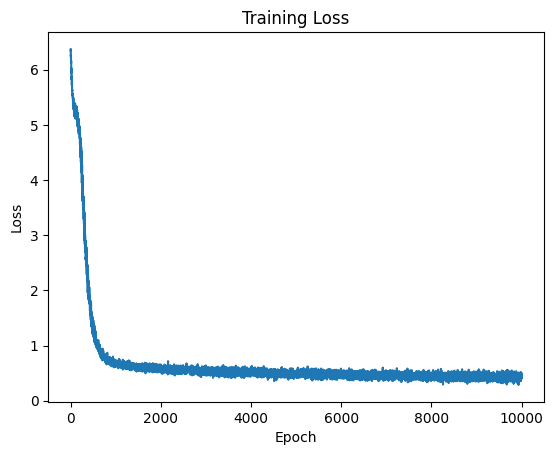

In [42]:
import matplotlib.pyplot as plt

# Plot the loss function
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [43]:
print(decode(Dante.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=500)[0].tolist()))

  a a a a a a a abarse,
tor che si sAenna,
evi, non mienat' altilca face,, e quiaro tracostra ondamente insser tuttendo,, lal foco gonda.
Da sé di tese a onamesse danto soggiuoli.
Di spi costrmitro fiha
settrò quinse songrinorase,
 medel noia voce.
Se poi
inver don si' io
del vo pospioro al parco tre, che 'l;onmer coggio cera,
e incostra d'ima
Oetellori li occhi da percererse e inti dicia col la mia suo dice la ' fadi
iena il se la monte ten colreza ilsoltadaggì ch'atri cerfozia,
se si de la quel loverda munia.
E se mae acrimigo
l'io eraio mogno
el me cerciviio elli seco al ciel meccomposto,
tu vede più gontal unde e, sì che cirolsisse detto aronda,
geta il mora terta
de la mia donda
la gente noa parose che onde
pale il cicon grazia ma protta questo re ditennepe
gel sol mimo la nato val cosa quonmor're, onidice ha sia dunaliglia il dalise da regodere.
Questo, siro
tro Dente, Dio re luianno!e che seco pregerà nel breoragha, e querti de la ve fuo die
mivo astico, che mio fia ilzi mai da 